## <center> **<span style="color: red">NLP</span> steps and explnation.**

Here we will use <span style="color: #ffd21e">**Hugging face**</span> trasformers pre trained models becuase it'll take so much effort to label<br>
all of our text columns "<ins>Comments, Describtion, Title</ins>" and also we will extract categorical and numirecal<br>
features from the text columns.<br><br>

##### **Steps in detail:**
<ul>
    <li>Extract categorical features from text columns sush as:<ol> 
        <li>Contains emojies
        <li>Positive or negative
        <li>Language
        <li>Views range</ol>
    <li> Doing analysis for most common words in comments and titles (Word cloud)
    <li> Extracing the length of the comments, descriptions & titles
    <li> One hot encoding
    <li> Stemming the data and tokenizing it
    <li> Saving those new data into new <strong>one</strong> Df to use in the final ML model

## <center> **Importing the <span style="color: red">Packeges</span>**<br>

In [1]:
import os
import time
import nltk
import emoji
import sqlite3
import svgwrite
import pandas as pd
import numpy as np
import transformers
import huggingface_hub

from PIL import Image
import matplotlib.pyplot as plt

from IPython.display import (
    set_matplotlib_formats)

from wordcloud import (WordCloud,
                       STOPWORDS,
                       ImageColorGenerator)

huggingface_hub.notebook_login()
set_matplotlib_formats('pdf', 'svg')

C:\Users\FreeComp\AppData\Local\Temp\ipykernel_10900\1364707940.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


## <center> **Reading the <span style="color: red">data</span>**

In [2]:
con = sqlite3.connect('../database.db')

df = pd.read_sql_query("""   
                        
                        SELECT *
                        FROM base_videos AS bv

                        INNER JOIN base_channels  AS bc ON
                            bc.channel_name = bv.channelTitle

                        INNER JOIN comments  AS c ON
                            c.video_id = bv.video_id""", con)

con.close()

df = df.T.drop_duplicates().T # dropping duplicated cols

In [3]:
df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,definition,duration_in_minutes,subscribers,total_views,date,video_count,about,country,Comments,LikeCounts,ReplyCounts
402,v0vB2wZUz18,Hitesh KS : Hindi Gaming,🏠 MERA NEW GHAR... | Wobbly Life Funny 😂 | Hit...,Hitesh KS Hindi Gaming Presents Buying My Firs...,"['hitesh ks', 'funny', 'comedy', 'funny moment...",2023-01-19 13:06:45+00:00,115516,5561,433,hd,11.179688,2450000,870785855,2016-07-28 00:00:00,1262,"I, Hitesh KS Hindi Gaming is an Indian Gamer H...",IN,Bhai wap life mein hide and seek,0,0
2905,sTiUzVRdFDM,Chisgule Gaming,Best Policies to Research [Don't make this sim...,The best way to use your prestige in the notic...,"['call of dragons', 'policy cod', 'policy call...",2023-04-01 23:33:28+00:00,28492,1031,112,hd,14.984375,200000,79782383,2017-07-02 00:00:00,2110,Get value and smash your enemies in Rise of Ki...,US,Is there a way to switch?,0,0
1343,U-yt7UdQWY0,Navalha - Freestyle Gaming,RIOT...¿QUE HAS HECHO? | Navalha - Wild Rift,Directo diario 15:00 CEST: https://www.twitch....,"['navalha', 'freestyle gaming', 'mobile gaming...",2023-03-18 15:00:16+00:00,34192,1830,241,hd,24.203125,352000,79200317,2016-10-12 00:00:00,2313,Qué te voy a contar que no sepas? \n\nSoy un s...,ES,Alguien sabe cómo poner la vida de los enemigo...,0,0
4005,RqjkaskCiz8,JKrew Gaming,BECOMING EVIL TWINS IN BROOKHAVEN!!,Becoming evil twins in Brookhaven!!\n#brookhav...,[],2023-01-26 21:00:10+00:00,1629913,3087,231,hd,8.453125,610000,389185865,2020-09-29 00:00:00,528,Welcome to JKrew Gaming! We are a gaming famil...,US,I love your videos keep up the great work and ...,0,2
4043,CTEVKckPFVo,PeterMc Gaming,I Made A 5'4 Center On NBA 2K...,I made a 5’4” center NBA 2K21 next gen! Every ...,"['nba 2k21', 'nba 2k21 shortest player', 'nba ...",2021-03-02 00:26:05+00:00,815030,14969,261,hd,15.25,509000,97060051,2014-07-21 00:00:00,800,I love NBA 2K so much!,US,Julian Newman be like,0,0


##  <center> **Extract <span style="color: red">categorical</span> features**

#### *Extract emojies count per text*

In [4]:
comments_emojis_counts: list = []
title_emojis_counts: list = []
desc_emojis_counts: list = []

for comment, title, desc in zip(df["Comments"], df["title"], df["description"]):
    
    comments_emojis_count: int = 0
    title_emojis_count: int = 0
    desc_emojis_count: int = 0
    
    for comment_char, title_char, desc_char in zip(comment, title, desc):
        
        if emoji.is_emoji(comment_char):
            comments_emojis_count += 1
            
        if emoji.is_emoji(title_char):
            title_emojis_count += 1
            
        if emoji.is_emoji(desc_char):
            desc_emojis_count += 1
    
    comments_emojis_counts.append(comments_emojis_count)
    title_emojis_counts.append(title_emojis_count)
    desc_emojis_counts.append(desc_emojis_count)

In [5]:
df["comments_emojis_count"] = comments_emojis_counts
df["title_emojis_count"] = title_emojis_counts
df["desc_emojis_count"] = desc_emojis_counts

df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,definition,...,date,video_count,about,country,Comments,LikeCounts,ReplyCounts,comments_emojis_count,title_emojis_count,desc_emojis_count
5627,2so6XyQKgSU,Nerdstalgic Gaming,Saints Row - On Day 170,The latest game in the Saints Row series came ...,"['Saints Row', 'Saints Row 2', 'Saints Row 202...",2023-02-09 18:00:02+00:00,17739,605,133,hd,...,2017-06-13 00:00:00,259,"Welcome to Nerdstalgic Gaming! Deep dives, bre...",US,So glad I still have 1 & 2. I have 3 but haven...,0,0,0,0,0
3095,u8UgTQwNS_M,Gaming Insects,😉How i Got Back Into Relationship With My Ex G...,😉How i Got Back Into Relationship With My Ex G...,['How i Got Back Into Relationship With My Ex ...,2023-03-14 07:30:11+00:00,431873,14183,1110,hd,...,2019-08-22 00:00:00,415,Guys Im Trying My Best Ki App Logo Ko Bohot En...,IN,Suno ase hat par hat rakke kuch nahi hoga tume...,0,0,0,1,1
1975,3zotm5eHZDE,Skvala Gaming,GTA 4 | PS3 Super Slim- POV Gameplay Impressio...,Hello everyone and welcome. Now the evolution ...,"['skvala gaming', 'gta 4', 'gta 4 ps3', 'gta 3...",2023-03-14 13:25:10+00:00,7332,312,108,hd,...,2018-02-03 00:00:00,559,"Hello, welcome to my channel.\nI create tech &...",DE,Would you buy a steam deck?,0,3,0,0,0
301,7yK59m6t0bk,WhitePro Gaming,Top 5 Headshot Mistakes in Free Fire | Headsho...,Follow me on instagram : https://www.instagram...,"['top 5 headshot mistakes in free fire', 'head...",2022-08-18 08:50:45+00:00,432534,28938,945,hd,...,2021-07-14 00:00:00,118,To Yaar Dekho 🔥\n\n----\n\n0 = 🎬 - 15 July 202...,IN,6:18 Ek video me apne bhi yehi bola tha 😂😂,0,0,2,0,0
1919,5p9nK-eACQA,aayuzita,Reagindo ao meu PRIMEIRO vídeo de MINECRAFT!,⭐ Conto com seu apoio: se inscreva no canal e ...,"['Ayu Brazil', 'Ayu Gaming', 'divertido', 'eng...",2022-11-24 21:27:02+00:00,7587,1412,122,hd,...,2020-06-30 00:00:00,474,,BR,Vc n poderia fazer lã com linha de aranha,1,0,0,0,1


#### *Language detection*

In [7]:
language_detector = transformers.pipeline("text-classification",
                                          model="papluca/xlm-roberta-base-language-detection",
                                          use_auth_token= True)

In [8]:
%%timeit
print(language_detector("هذا أطول نص قد تقرأه على الإطلاق إنه طويل للغاية", max_length=128))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
3.63 s ± 211 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Looks like we will take a lot to <ins>just classify the language</ins> of each text at least: $30\times100$ second whitch equalls <span style="color: red">**50 minutes.**</span><br>
So we can't do translation for now becuase it at least may take **5 hours** to run so we will just use this language detetion and<br>
optimize it by just sellecting one text column to detect which will be **Description column** and use the detected languages to<br>
pridect video and comments language.<br><br>
But we will detect the language using the **country of this video**

In [9]:
df["country"].unique()

array(['DE', 'US', 'PL', 'SA', 'NP', 'CA', 'ES', 'TR', 'IN', 'EG', 'GB',
       'MX', 'BR', 'PK', 'FR', 'VN', 'ID', 'AU', 'HU', 'NL', 'BG', 'JP',
       'SG', 'TH', 'PH', 'MT', 'PE', 'SE', 'IT', 'KR', 'TW', 'FI', 'DZ',
       'BD', 'AR'], dtype=object)

In [10]:
country_languages = {
    'DE': 'German',
    'US': 'English', 'PL': 'Polish',
    'SA': 'Arabic', 'NP': 'Nepali',
    'CA': 'English', 'ES': 'Spanish',
    'TR': 'Turkish', 'IN': 'Hindi',
    'EG': 'Arabic', 'GB': 'English',
    'MX': 'Spanish', 'BR': 'Portuguese',
    'PK': 'Urdu', 'FR': 'French',
    'VN': 'Vietnamese', 'ID': 'Indonesian',
    'AU': 'English', 'HU': 'Hungarian',
    'NL': 'Dutch', 'BG': 'Bulgarian',
    'JP': 'Japanese', 'SG': 'English', 
    'TH': 'Thai', 'PH': 'Tagalog',
    'MT': 'Maltese', 'PE': 'Spanish',
    'SE': 'Swedish', 'IT': 'Italian',
    'KR': 'Korean', 'TW': 'Chinese',
    'FI': 'Finnish', 'DZ': 'Arabic',
    'BD': 'Bengali', 'AR': 'Spanish'}

df["language"] = df["country"].replace(country_languages)

This way may not be so accurate in detecting languages becuase there are some **indian videos** specifically with english and<br>
because some commetns come in deffrint languages but at least this way is more accurate than `roberta-language-detection`<br>
model because this model sometimes come with wierd 

#### *Sentiment analysis*

In [11]:
sentiment_classifier = transformers.pipeline(model= "finiteautomata/bertweet-base-sentiment-analysis")
print(sentiment_classifier("Hello here in my analysis, Have a nice day !!"))

Downloading:   0%|          | 0.00/2.72k [00:00<?, ?B/s]

[{'label': 'POS', 'score': 0.9883897304534912}]


In [12]:
def my_sentiment_classifier(text: str) -> np.int8:
    """This code takes a text and return you if it's positive
        or negative as 1 for positive, 0 for natural -1 for negative
        and -10 for unclassified.
    
    @params: a string text
    @return: 1, 0 or -1 in np.int8 dtype"""
    
    sentiment_type_encoder: dict = {"POS": 1,
                                    "NEG": -1,
                                    "NEU": 0,
                                    "unclassified": -10}
    
    try:
        sentiment_type: str = sentiment_classifier(text)[0]["label"]
        
    except:
        sentiment_type: str = "unclassified"
        
    return  np.int8(sentiment_type_encoder[sentiment_type])

In [ ]:
df["sentiments"] = df["Comments"][:5].apply(
    lambda x: my_sentiment_classifier(x))

In [ ]:
df[["sentiments", "Comments"]]

#### *Views range*

## <center><strong>Text visualiztion with<span style = "color: red"> WordCloud</span></strong></center>

In [19]:
coloring = np.array(Image.open("../imgs/youtube_gaming_logo.png"))
stopwords = set(STOPWORDS)

comments = ''.join(df["Comments"][df["language"] == "English"].values.flatten())

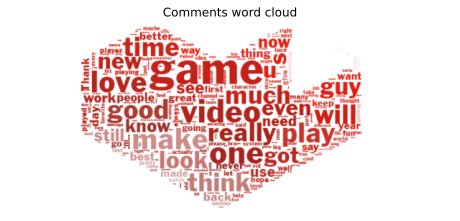

In [23]:
wc = WordCloud(background_color= "white", max_words= 300, mask= coloring,
               stopwords= stopwords, max_font_size= 80, random_state= 42,
               font_path= '../Data analysis/assets/fonts/FranklinGothic.ttf')

wc.generate(comments)

image_colors = ImageColorGenerator(np.array(coloring))

fig, ax = plt.subplots(1)

ax.imshow(wc.recolor(color_func= image_colors), interpolation="bilinear")
ax.set_axis_off()

plt.title("Comments word cloud")
fig.set_size_inches(8, 6)
plt.savefig("../plots/comments_word_cloud.png")
plt.show()

Now we will make a word cloud for **video titles data**

In [24]:
popular_emojis = ["😊", "😍", "😘", "😜", "😝", "😂", "😭", "😡", "😠", "😩", "😫", "😞", "😟", "😢", "😥", "😰", "😱",
                       "😳", "😷", "👍", "👎", "👌", "👏", "🙌", "👋", "💪", "🙏", "❤️", "💔", "💕", "💖", "💘", "💙", "💚",
                       "💛", "💜", "💯", "🔥", "🌟", "✨", "⭐", "🌈", "🌺", "🍕", "🍔", "🍟", "🍦", "🍭", "🍩", "🍪", "🍺",
                       "🍻", "🍷", "🍸", "🎂", "🎁", "🎉", "🎊", "🎈", "🎵", "🎶", "🎼", "🎧", "🎤", "🎸", "🎹", "🎺", "🎷",
                       "🎻", "🎬", "🎥", "🎦", "📷", "📹", "📺", "📻", "💻", "📱", "💡", "🔑", "🔨", "🔥", "💰", "💳", "💼",
                       "📅", "📆", "📈", "📉", "📊", "📋", "📎", "📏", "📐", "🔒", "🔓", "🔍", "🔎", "🚀", "🚑", "🚒", "🚓",
                       "🚕", "🚗", "🚙", "🚚", "🚢", "🚤", "🚲", "🚶", "🚶‍♀️", "🏃", "🏃‍♀️", "⚽", "🏀", "🏈", "🎾", "🏐", "🏉",
                       "🎱", "🏓", "🏸", "🥊", "🥋", "🎮", "🕹️", "🎲", "🃏"]


for emoji in popular_emojis:
    stopwords.add(emoji)
    
titels = ''.join(df["title"][df["language"] == "English"].values.flatten())

In [26]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import numpy as np

coloring = np.array(Image.open("../imgs/joystick.png"))

wc = WordCloud(background_color= "white", max_words= 2000, mask= coloring,
               stopwords= STOPWORDS, max_font_size= 80, random_state= 42,
               font_path= '../Data analysis/assets/fonts/FranklinGothic.ttf')

wc.generate(titels)

image_colors = ImageColorGenerator(np.array(coloring))

# Generate the SVG code for the WordCloud
svg_code = wc.to_svg(embed_font=True)

# Save the SVG code to a file
with open("../plots/videos_titels_word_cloud.svg", "w") as f:
    f.write(svg_code)


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


UnicodeEncodeError: 'charmap' codec can't encode character '\u1001' in position 9494: character maps to <undefined>

## <center><strong><span style = "color: red">Extra</span> features